In [1]:
import pandas as pd
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
file_path = '../elidata/Merged_Ni_lessthan15km.csv'

df = pd.read_csv(file_path, index_col=0)
df.head(3)

,Unnamed: 0_x,Ni,Cu,Co,Pd,Au,Pt,Rh,Fe,S,Ag,lat,long,Unnamed: 0_y,minedex_coords,minedex_site,wamex_lat,wamex_lon,distance
0,33,56.0,420.0,9.0,14.0,0.01,1.0,NaN,NaN,NaN,NaN,-17.234642,128.032146,46661,"(-17.34893, 128.022095)",S0001442,-17.234642,128.032146,12.693593881734987 km
1,33,56.0,420.0,9.0,14.0,0.01,1.0,NaN,NaN,NaN,NaN,-17.234642,128.032146,46662,"(-17.31078, 128.023499)",S0002890,-17.234642,128.032146,8.476376684524638 km
2,33,56.0,420.0,9.0,14.0,0.01,1.0,NaN,NaN,NaN,NaN,-17.234642,128.032146,46663,"(-17.3526, 128.027695)",S0019720,-17.234642,128.032146,13.063277176872425 km


In [3]:
df.shape

(150625, 19)

In [4]:
df[df['Co'] == df['Co'].max()]

,Unnamed: 0_x,Ni,Cu,Co,Pd,Au,Pt,Rh,Fe,S,Ag,lat,long,Unnamed: 0_y,minedex_coords,minedex_site,wamex_lat,wamex_lon,distance
15478,39939,67647.0,1838.0,57408.0,0.0,0.0,6.0,0.0,1630.0,0.0364,1.0,-26.061367,127.580028,73190,"(-26.107121, 127.696899)",S0019102,-26.061367,127.580028,12.744010894761297 km
15479,39939,67647.0,1838.0,57408.0,0.0,0.0,6.0,0.0,1630.0,0.0364,1.0,-26.061367,127.580028,73191,"(-26.107121, 127.696899)",S0224398,-26.061367,127.580028,12.744010894761297 km


In [5]:
df_unique = df.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y', 'lat', 'long', 
                     'minedex_coords', 'minedex_site',
                    'distance'])

df_unique = df_unique.drop_duplicates()

In [6]:
print(f"Amount of Duplicate rows: {df.shape[0] - df_unique.shape[0]}")

Amount of Duplicate rows: 127392


In [7]:
df_unique.shape

(23233, 12)

### WAMEX data

 ·      Cobalt associated with nickel (and copper) in so-called orthomagmatic (igneous) mafic to ultramafic volcanic (komatiite)-hosted and intrusion-hosted deposits
 
 
 Cobalt is a chemical element with the symbol Co and atomic number 27. Like nickel, cobalt is found in the Earth's crust only in a chemically combined form, save for small deposits found in alloys of natural meteoric iron. The free element, produced by reductive smelting, is a hard, lustrous, silver-gray metal. Wikipedia
Symbol: Co <br>
Electron configuration: [Ar] 3d74s2 <br>
Atomic number: 27 <br>
Atomic mass: 58.933195 u <br>
Melting point: 1,495 °C <br>
Discovered: 1735 <br>
Discoverer: Georg Brandt <br>

### Nickel, Copper and Cobalt Interactions

In [8]:
# most common pair in MINEDEX data.
abdundant_minerals = ['Copper', 'Nickel', 'Iron', 'Gold', 'Silver'] #'Sulfur', 'Palladium','Platinum',
critical_mineral = ['Cobalt']

full_to_atomic = {
    "Copper": "Cu",
    "Cobalt": "Co",
    "Nickel": "Ni",
    "Iron": "Fe",
    "Sulfur": "S",
    "Palladium": "Pd",
    "Platinum": "Pt",
    "Gold": "Au",
    "Silver": "Ag"
}


In [9]:
def get_clean_mineral_col(df):
    new_cols = []
    for col in df.columns: 
        if "ppm" in col:
            new_cols.append(col.split('_')[0])
        else:
            new_cols.append(col)
            
    return new_cols

df_unique.columns = get_clean_mineral_col(df_unique)

In [10]:
df_unique.head(2)

,Ni,Cu,Co,Pd,Au,Pt,Rh,Fe,S,Ag,wamex_lat,wamex_lon
0,56.0,420.0,9.0,14.0,0.010,1.0,NaN,NaN,NaN,NaN,-17.234642,128.032146
5,31.0,195.0,6.0,10.0,0.007,1.0,NaN,NaN,NaN,NaN,-17.234642,128.032146


In [11]:
minerals = abdundant_minerals + critical_mineral

minerals_atomic = [full_to_atomic[mineral] for mineral in minerals]
minerals_atomic

['Cu', 'Ni', 'Fe', 'Au', 'Ag', 'Co']

In [12]:
input_cols = ['wamex_lat', 'wamex_lon'] + minerals_atomic

In [13]:
df_inputs = df_unique[input_cols]
df_inputs.head(2)

,wamex_lat,wamex_lon,Cu,Ni,Fe,Au,Ag,Co
0,-17.234642,128.032146,420.0,56.0,NaN,0.010,NaN,9.0
5,-17.234642,128.032146,195.0,31.0,NaN,0.007,NaN,6.0


In [14]:
def replace_neg9999(val):
    if val == -9999: 
        return 0
    else:
        return val
    
    
def abs_halve_neg_val(val):
    if val < 0: 
        return abs(val) / 2
    else: 
        return val

def clean_assays(df):
    df = df.applymap(replace_neg9999)
    df = df.applymap(abs_halve_neg_val)

    # all 9999 -> 0 values are removed
    indexs_0 = df[df.values == 0].index
    df = df.drop(index=indexs_0)
    
    return df

def abundant_ratio(row, abundant_mineral):
    return row / row[abundant_mineral]


In [15]:
df_minerals = df_inputs.drop(columns=['wamex_lat', 'wamex_lon'])

df_inputs.loc[:, df_minerals.columns] = clean_assays(df_inputs.loc[:,df_minerals.columns])
df_inputs.shape

C:\Users\elisi\Miniconda3\envs\minerals\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\elisi\Miniconda3\envs\minerals\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


(23233, 8)

## `drop_na`

In [16]:
df_inputs = df_inputs.dropna()
df_inputs.shape

(8875, 8)

<AxesSubplot:ylabel='Frequency'>

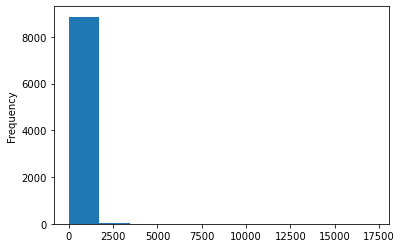

In [17]:
df_inputs['Co'].plot(kind='hist')

### LARGE Colbalt deposits

In [18]:
df_inputs[df_inputs['Co'] > 10000]

,wamex_lat,wamex_lon,Cu,Ni,Fe,Au,Ag,Co
52865,-32.096211,121.651299,46.0,10782.0,12120.0,0.0025,0.16,17180.0


### Apply Ratio Transform

In [19]:
# df_inputs.loc[:, df_minerals.columns] = df_inputs.loc[:, df_minerals.columns].apply(
#                                                             abundant_ratio, abundant_mineral='Ni',
#                                                             axis=1)

In [20]:
df_inputs['Co'].describe()

count     8875.000000
mean        51.720150
std        232.157057
min          0.100000
25%          8.800000
50%         20.000000
75%         46.050000
max      17180.000000
Name: Co, dtype: float64

### Log Transform

In [21]:
import numpy as np

<AxesSubplot:ylabel='Frequency'>

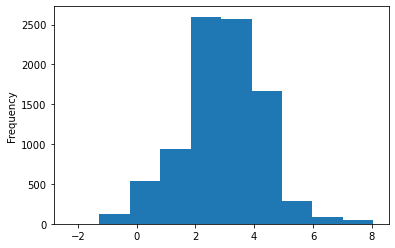

In [22]:
np.log(df_inputs[df_inputs['Co'] < 5000]['Co']).plot(kind='hist')

In [23]:
df_inputs.loc[:, df_minerals.columns] = df_inputs.loc[:,df_minerals.columns].apply(np.log, axis=1)

### Independent Variables

In [24]:
from sklearn.preprocessing import StandardScaler

## Plotting First 100 Observations

<AxesSubplot:>

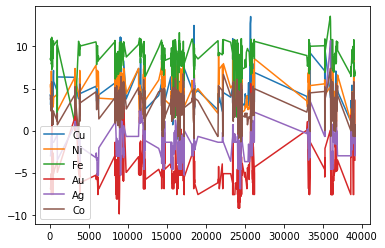

In [25]:
df_inputs[minerals_atomic][:1000].plot()

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyrolite.plot import pyroplot
from pyrolite.plot.density import density
from pyrolite.comp.codata import close

### Plot before ratio transform (else Ni is 1)

In [27]:
# plotting_minerals = ['Ni', 'Co', 'Ni']

# df_plot = df_inputs[plotting_minerals]

In [28]:
# fig, ax = plt.subplots(
#     1,
#     3,
#     sharex=True,
#     sharey=True,
#     figsize=(15, 5),
#     subplot_kw=dict(projection="ternary"),
# )
# df_plot.pyroplot.scatter(ax=ax[0], alpha=0.05, c="k")
# for a, mode in zip(ax[1:], ["hist", "density"]):
#     df_plot.pyroplot.density(ax=a, mode=mode)
#     a.set_title("Mode: {}".format(mode), y=1.2)

# plt.tight_layout()
# plt.show()

In [29]:
df_inputs

,wamex_lat,wamex_lon,Cu,Ni,Fe,Au,Ag,Co
106,-17.742535,127.903385,4.174387,5.205105,8.503094,-6.907755,-2.995732,4.158883
109,-17.737059,127.903390,4.347694,5.510198,8.630522,-6.907755,-2.995732,4.127134
112,-17.737963,127.903422,4.109233,5.190732,8.478452,-6.907755,-2.995732,3.688879
115,-17.734329,127.903425,3.077312,4.580877,8.393895,-6.907755,-2.995732,3.806662
193,-30.486709,121.992519,4.770685,4.143135,9.341369,-5.115996,-0.693147,2.995732
...,...,...,...,...,...,...,...,...
134162,-27.697064,120.657557,5.298317,4.605170,9.629051,-4.605170,0.000000,3.401197
135965,-27.699810,120.655572,8.160518,7.090077,10.825760,-4.605170,-1.386294,2.995732
136098,-27.700048,120.655769,7.718685,6.684612,10.791379,-4.605170,-1.386294,2.995732
143779,-27.699929,120.655701,7.313220,7.090077,10.819778,-5.298317,-0.693147,3.555348


### Drop `Ni`

In [30]:
# df_inputs = df_inputs.drop(columns=['Ni'])

### Split Indepdent from dependents

In [31]:
y = df_inputs['Co']
X = df_inputs.drop(columns=['Co'])

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True)

lr = LinearRegression()

lr.fit(X_train, y_train)
train_preds = lr.predict(X_train)
test_preds = lr.predict(X_test)

from sklearn.metrics import mean_squared_error

print(f"Train MSE: {mean_squared_error(train_preds, y_train)}")
print(f"Test MSE: {mean_squared_error(test_preds, y_test)}")

Train MSE: 0.6385715951918669
Test MSE: 0.6530622576666459


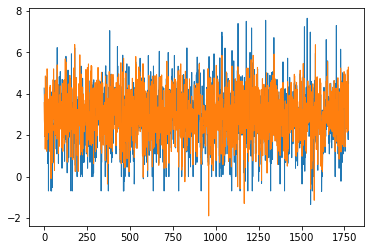

In [33]:
plt.plot(range(0, len(test_preds)), y_test, test_preds)

#### TODO: See why is underestimating in high raneg

In [34]:
# rename for visualisation
X_train = X_train.rename(columns={
    "wamex_lat": "Latitude",
    "wamex_lon": "Longitude"
})

In [35]:
def latex_with_lines(df, *args, **kwargs):
    kwargs['column_format'] = '|'.join([''] + ['l'] * df.index.nlevels
                                            + ['r'] * df.shape[1] + [''])
    res = df.to_latex(*args, **kwargs)
    return res.replace('\\\\\n', '\\\\ \\hline\n')

In [36]:
lr_coefs = pd.Series(lr.coef_, X_train.columns,).sort_values()

In [37]:
print(lr_coefs.to_latex())

\begin{tabular}{lr}
\toprule
{} &         0 \\
\midrule
Longitude & -0.084547 \\
Au        & -0.069107 \\
Ag        & -0.025527 \\
Latitude  & -0.009469 \\
Fe        &  0.154495 \\
Cu        &  0.182415 \\
Ni        &  0.557294 \\
\bottomrule
\end{tabular}



### science plot style

In [38]:
plt.style.use('science')

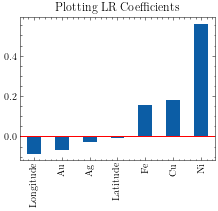

In [39]:
ax = lr_coefs.plot(kind='bar', title='Plotting LR Coefficients')
ax.axhline(y=0, color='red')
plt.savefig('./img/lrcoefplot.pdf')

#### Random Forrest

In [40]:
rf = RandomForestRegressor(n_estimators=10,  min_samples_split=3)

rf.fit(X_train, y_train)
train_preds = rf.predict(X_train)
test_preds = rf.predict(X_test)

print(f"Train MSE: {mean_squared_error(train_preds, y_train)}")
print(f"Test MSE: {mean_squared_error(test_preds, y_test)}")

Train MSE: 0.07169944073816985
Test MSE: 0.37030786608105176


<AxesSubplot:ylabel='Frequency'>

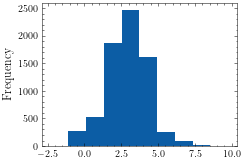

In [41]:
y_train.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

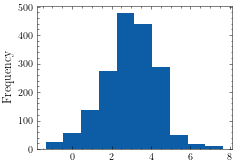

In [42]:
y_test.plot(kind='hist')

In [43]:
pd.Series(rf.feature_importances_,X_train.columns).sort_values(ascending=False)

Ni           0.614055
Fe           0.105169
Au           0.081291
Cu           0.066620
Longitude    0.066174
Latitude     0.036674
Ag           0.030015
dtype: float64

### Model Interpretation

In [44]:
import shap

In [45]:
explainer = shap.LinearExplainer(lr, X_train, feature_dependence="independent")
shap_values = explainer.shap_values(X_test)
X_test_array = X_test.to_numpy() 

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


In [46]:

# plt.style.use()


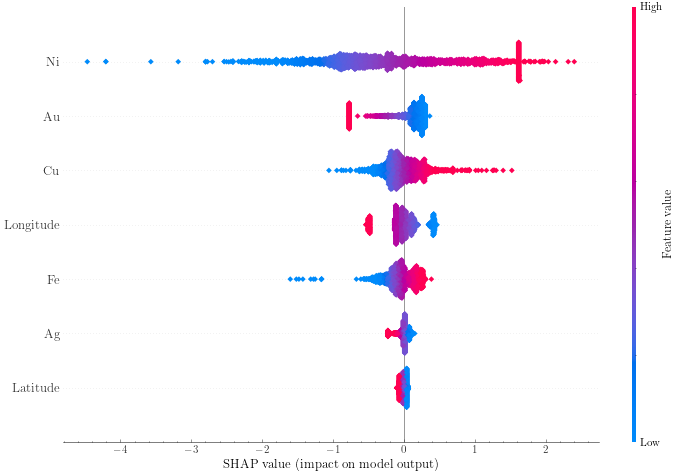

In [47]:
plt.figure()
shap.summary_plot(shap_values, X_test_array, 
                  feature_names=X_train.columns,
                 plot_size=(12,8), show=False)
plt.savefig('./img/shapswarm_with_ni.jpg', dpi=500)

### `force_plot`

In [48]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [49]:
# load javascript plugin
shap.initjs()

In [50]:
X_test.iloc[1]

wamex_lat    -31.374817
wamex_lon    121.428821
Cu             4.406719
Ni             4.290459
Fe             8.357024
Au            -3.442019
Ag            -1.386294
Name: 106287, dtype: float64

In [51]:
ind = 1

plt.figure()
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
    feature_names=X_train.columns
)
plt.savefig('./img/force_plot_lat1.jpg', dpi=500)

<Figure size 640x480 with 0 Axes>

In [52]:
ind = -5

print(X_test.iloc[ind])

plt.figure()
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
    feature_names=X_train.columns, show=False, matplotlib=False
)
plt.savefig('./img/force_plot_lat_neg21.jpg', dpi=500)

wamex_lat    -21.055008
wamex_lon    116.964694
Cu             1.677097
Ni             5.298317
Fe             8.586719
Au            -4.509860
Ag            -0.916291
Name: 44396, dtype: float64


<Figure size 640x480 with 0 Axes>

In [53]:
# ind = 100
# shap.force_plot(
#     explainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
#     feature_names=X_test.columns
# )


### Longitude - Dependence plot

In [54]:
shap_values = explainer.shap_values(X)

In [55]:
X

,wamex_lat,wamex_lon,Cu,Ni,Fe,Au,Ag
106,-17.742535,127.903385,4.174387,5.205105,8.503094,-6.907755,-2.995732
109,-17.737059,127.903390,4.347694,5.510198,8.630522,-6.907755,-2.995732
112,-17.737963,127.903422,4.109233,5.190732,8.478452,-6.907755,-2.995732
115,-17.734329,127.903425,3.077312,4.580877,8.393895,-6.907755,-2.995732
193,-30.486709,121.992519,4.770685,4.143135,9.341369,-5.115996,-0.693147
...,...,...,...,...,...,...,...
134162,-27.697064,120.657557,5.298317,4.605170,9.629051,-4.605170,0.000000
135965,-27.699810,120.655572,8.160518,7.090077,10.825760,-4.605170,-1.386294
136098,-27.700048,120.655769,7.718685,6.684612,10.791379,-4.605170,-1.386294
143779,-27.699929,120.655701,7.313220,7.090077,10.819778,-5.298317,-0.693147


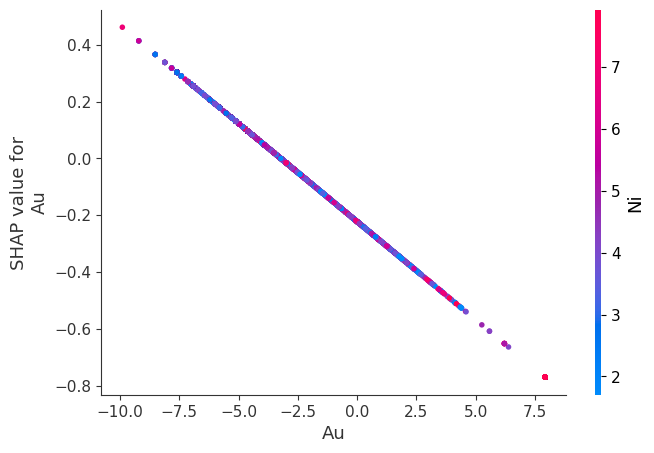

In [56]:
shap.dependence_plot("rank(1)", shap_values, X)

### Jobs to do:

- Investigate Overfitting of RF, what is causing it.
- Try another ML model.
- Compare Model performances with entire minerals dataset (not just the subset).
- Compare different mineral comibinations
- Compare without ratio function
- Forcing by Long/ Lat sub-groups.